<a href="https://colab.research.google.com/github/manuvikash/Drawing-Classifier/blob/main/Drawing_Classifier_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset. 

In [1]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'
#Downloads textfile containing subset of 100 labels

--2022-08-31 05:40:49--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]     760  --.-KB/s    in 0s      

2022-08-31 05:40:49 (45.2 MB/s) - ‘mini_classes.txt’ saved [760/760]



Read the classes names 

In [3]:
f = open("mini_classes.txt","r")
classes = f.readlines()
#reading the file
f.close()

In [4]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [5]:
!mkdir data

In [6]:
import urllib.request
def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in classes:        
        cls_url = c.replace('_', '%20')
        path = base+cls_url+'.npy'
        print(path)
        urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [7]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

# Imports 

In [2]:
import os
import glob
import numpy as np
from tensorflow.python.keras import layers
from tensorflow import keras 
import tensorflow as tf

print(len(os.listdir('data')))

100


# Load the Data 

Loading 4000 images from every class due to storage and computing power limitations.  

In [3]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [4]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [5]:
print(len(x_train)) #Training-Testing split is 80-20

320000


Display a random image

knife


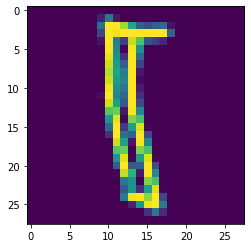

In [6]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data 

In [7]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model 

In [25]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten(input_shape=x_train.shape[1:]))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 

# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])


# Training 

In [26]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
1125/1125 - 7s - loss: 1.8843 - top_k_categorical_accuracy: 0.7872 - val_loss: 1.3527 - val_top_k_categorical_accuracy: 0.8821 - 7s/epoch - 6ms/step
Epoch 2/5
1125/1125 - 6s - loss: 1.2283 - top_k_categorical_accuracy: 0.8947 - val_loss: 1.1505 - val_top_k_categorical_accuracy: 0.9040 - 6s/epoch - 5ms/step
Epoch 3/5
1125/1125 - 6s - loss: 1.0748 - top_k_categorical_accuracy: 0.9117 - val_loss: 1.0585 - val_top_k_categorical_accuracy: 0.9149 - 6s/epoch - 6ms/step
Epoch 4/5
1125/1125 - 6s - loss: 0.9865 - top_k_categorical_accuracy: 0.9206 - val_loss: 0.9897 - val_top_k_categorical_accuracy: 0.9202 - 6s/epoch - 5ms/step
Epoch 5/5
1125/1125 - 6s - loss: 0.9276 - top_k_categorical_accuracy: 0.9261 - val_loss: 0.9625 - val_top_k_categorical_accuracy: 0.9227 - 6s/epoch - 6ms/step


# Testing 

In [27]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 92.22%


# Inference 

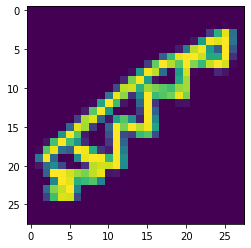

In [28]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 

In [29]:
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

['saw', 'syringe', 'wristwatch', 'screwdriver', 'bird']


# Store the classes 

In [30]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [22]:
!pip install tensorflowjs 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflowjs-3.20.0-py3-none-any.whl (81 kB)
  Using cached flax-0.6.0-py3-none-any.whl (180 kB)
     |████████████████████████████████| 40 kB 4.8 MB/s 
     |████████████████████████████████| 1.0 MB 11.7 MB/s 
     |████████████████████████████████| 217 kB 6.5 MB/s 
     |████████████████████████████████| 145 kB 59.7 MB/s 
     |████████████████████████████████| 51 kB 2.2 MB/s 
     |████████████████████████████████| 76 kB 2.2 MB/s 
  Created wheel for jax: filename=jax-0.3.16-py3-none-any.whl size=1197715 sha256=32e3345148098581a91810b91f610ff0356c15c4ad789c38c3e14671a3208622
  Stored in directory: /root/.cache/pip/wheels/b9/0d/a2/2091279bf29b90a2211a271f6f006ef13a656211a9e69ba1e3
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
  Attempting uninstall: pack

# Save and Convert 

In [31]:
model.save('keras.h5')

NotImplementedError: ignored

In [ ]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

# Zip and Download 

In [ ]:
!cp class_names.txt model/class_names.txt

In [ ]:
!zip -r model.zip model 

In [ ]:
from google.colab import files
files.download('model.zip')